# USAspending Physical Security Contract Solicitation Analysis

## Table of Contents
1. [Setup](#setup)
2. [Data Preparation](#data-preparation)
3. [Question 1 – How solicitation procedures shifted over time](#question-1)
   - [Aggregated metrics](#question-1-metrics)
   - [Visualisation](#question-1-visualisation)
4. [Question 2 – Award value comparisons by solicitation procedure](#question-2)
   - [Summary statistics](#question-2-summary)
   - [Distribution views](#question-2-visuals)
5. [Key Takeaways](#key-takeaways)


## Setup <a id="setup"></a>
This notebook answers questions from `docs/analysis_plan.md` using only observable USAspending fields.
We track fiscal-year shifts in the mix of `solicitation_procedures` for physical security contracts, focusing on NAICS codes enumerated in `NAICs.md`.

**Value fields referenced throughout**

- `federal_action_obligation` — incremental obligations recorded for the action.
- `base_and_exercised_options_value` — funded base plus exercised options.
- `base_and_all_options_value` — base plus the ceiling for all options.
- `current_total_value_of_award` — running total inclusive of current modifications.
- `potential_total_value_of_award` — potential ceiling after all modifications/options.
- `total_outlayed_amount_for_overall_award` — cumulative outlays reported for the award.

Annualised contract value equals each award value divided by its performance duration in years; we compute it for the base-plus-options and potential totals when both start and end dates are available.

**Outlier filtering**
- Contracts with `base_and_all_options_value` below 0 or above USD 1,000,000,000 are excluded from every analysis cell.

In [1]:
import sys
from pathlib import Path

NOTEBOOK_DIR = Path().resolve()
for candidate in (NOTEBOOK_DIR, NOTEBOOK_DIR.parent, NOTEBOOK_DIR.parent.parent):
    if (candidate / 'scripts').exists():
        if str(candidate) not in sys.path:
            sys.path.insert(0, str(candidate))
        break

import pandas as pd
from scripts.usaspending_utils import (
    prepare_solicitation_dataset,
    compute_solicitation_timeseries,
    pivot_solicitation_share,
    prepare_cost_dataset,
    summarize_cost_by_procedure,
)
from scripts.modeling_utils import candidate_feature_columns, extract_linear_feature_importance, train_log_linear_model_with_split
from scripts.visualization_utils import plot_competition_value_profile
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display


In [2]:
pd.set_option('display.float_format', '{:,.2f}'.format)
import seaborn as sns
sns.set_theme(style='whitegrid')
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12


## Data Preparation <a id="data-preparation"></a>
The dataset pulls prime transactions filtered to the NAICS codes maintained in `NAICs.md` (currently security-guard services).
Only the raw fields required for solicitation analysis are loaded; no derived "quality" scores are created.


In [3]:
solicitation_df = prepare_solicitation_dataset()

records_total = len(solicitation_df)
fiscal_year_min = int(solicitation_df['action_date_fiscal_year'].min())
fiscal_year_max = int(solicitation_df['action_date_fiscal_year'].max())
unique_procedures = solicitation_df['solicitation_procedures'].nunique(dropna=True)
total_obligation = solicitation_df['federal_action_obligation'].sum()

overview = pd.DataFrame(
    {
        'Metric': [
            'Records loaded',
            'Fiscal year coverage',
            'Distinct solicitation procedures',
            'Total federal action obligation (USD billions)',
        ],
        'Value': [
            f"{records_total:,}",
            f"FY{fiscal_year_min} – FY{fiscal_year_max}",
            unique_procedures,
            f"{total_obligation / 1e9:,.1f}",
        ],
    }
)

display(overview)
display(solicitation_df.head())


# Remove extreme total values (<0 or >$1B)
base_values = solicitation_df["base_and_all_options_value"]
between_mask = base_values.between(0, 1_000_000_000, inclusive="both")
mask = between_mask.fillna(False) | base_values.isna()
solicitation_outliers_removed = (~mask).sum()
solicitation_df = solicitation_df[mask]


,Metric,Value
0,Records loaded,"220,528"
1,Fiscal year coverage,FY2008 – FY2026
2,Distinct solicitation procedures,9
3,Total federal action obligation (USD billions),72.5


,action_date_fiscal_year,solicitation_procedures,federal_action_obligation,base_and_exercised_options_value,base_and_all_options_value,current_total_value_of_award,potential_total_value_of_award,total_outlayed_amount_for_overall_award,extent_competed,number_of_offers_received
0,2025,SUBJECT TO MULTIPLE AWARD FAIR OPPORTUNITY,0.00,NaN,0.00,NaN,"39,453,945.58",NaN,FULL AND OPEN COMPETITION,2.00
1,2025,SUBJECT TO MULTIPLE AWARD FAIR OPPORTUNITY,0.00,NaN,"737,962.78",NaN,"40,191,908.36",NaN,FULL AND OPEN COMPETITION,2.00
2,2013,NEGOTIATED PROPOSAL/QUOTE,"256,345.56",0.00,"256,345.56",NaN,NaN,NaN,FULL AND OPEN COMPETITION,1.00
3,2014,NEGOTIATED PROPOSAL/QUOTE,"245,300.00",0.00,"245,300.00",NaN,NaN,NaN,FULL AND OPEN COMPETITION,1.00
4,2019,SIMPLIFIED ACQUISITION,"10,941.60","10,941.60","10,941.60","10,941.60","10,941.60",NaN,COMPETED UNDER SAP,1.00


The pull contains every prime transaction in the filtered database where the NAICS code matches the security-guard segment. The head preview confirms that only observable solicitation attributes are used for subsequent group-bys.

## Question 1 – How solicitation procedures shifted over time <a id="question-1"></a>
We examine the distribution of `solicitation_procedures` by fiscal year and report both award counts and obligations.
Optional context on competition intensity comes from `number_of_offers_received`."


### Aggregated metrics <a id="question-1-metrics"></a>

In [4]:
timeseries = compute_solicitation_timeseries(solicitation_df)
# Exclude future fiscal years with partial reporting (>= 2026)
cutoff_year = 2025
timeseries_clean = timeseries[timeseries['action_date_fiscal_year'] <= cutoff_year].copy()

# Compute shares for readability
timeseries_clean['awards_share'] = timeseries_clean.groupby('action_date_fiscal_year')['awards_total'].transform(lambda x: x / x.sum())
timeseries_clean['obligation_share'] = timeseries_clean.groupby('action_date_fiscal_year')['obligation_total'].transform(lambda x: x / x.sum())

# Snapshot of the most recent full fiscal year
def format_snapshot(df, year):
    snapshot = df[df['action_date_fiscal_year'] == year].copy()
    snapshot = snapshot.sort_values('awards_total', ascending=False)
    snapshot['awards_share_pct'] = snapshot['awards_share'] * 100
    snapshot['obligation_share_pct'] = snapshot['obligation_share'] * 100
    snapshot['obligation_total_bil'] = snapshot['obligation_total'] / 1e9
    cols = [
        'solicitation_procedures',
        'awards_total',
        'awards_share_pct',
        'obligation_total_bil',
        'obligation_share_pct',
        'median_offers',
    ]
    return snapshot[cols].round(
        {
            'awards_share_pct': 1,
            'obligation_total_bil': 2,
            'obligation_share_pct': 1,
            'median_offers': 1,
        }
    )

latest_year = timeseries_clean['action_date_fiscal_year'].max()
latest_snapshot = format_snapshot(timeseries_clean, latest_year)

overall_summary = (
    timeseries_clean.groupby('solicitation_procedures')
    .agg(
        awards_total=('awards_total', 'sum'),
        obligation_total=('obligation_total', 'sum'),
        median_offers=('median_offers', 'median'),
    )
    .assign(
        awards_share=lambda df: df['awards_total'] / df['awards_total'].sum(),
        obligation_share=lambda df: df['obligation_total'] / df['obligation_total'].sum(),
        obligation_total_bil=lambda df: df['obligation_total'] / 1e9,
    )
    .sort_values('awards_total', ascending=False)
    .round(
        {
            'median_offers': 1,
            'awards_share': 3,
            'obligation_share': 3,
            'obligation_total_bil': 2,
        }
    )
)

print(f"Latest completed fiscal year: FY{latest_year}")
display(latest_snapshot)
print("\nAggregate FY2008–FY2025 totals by solicitation procedure")
display(overall_summary)

Latest completed fiscal year: FY2025


,solicitation_procedures,awards_total,awards_share_pct,obligation_total_bil,obligation_share_pct,median_offers
126,NEGOTIATED PROPOSAL/QUOTE,5534,49.40,3.68,65.70,10.00
129,SIMPLIFIED ACQUISITION,3903,34.80,0.13,2.30,1.00
130,SUBJECT TO MULTIPLE AWARD FAIR OPPORTUNITY,1448,12.90,1.45,25.80,3.00
127,ONLY ONE SOURCE,303,2.70,0.31,5.60,1.00
125,,13,0.10,0.00,0.00,NaN
128,SEALED BID,7,0.10,0.03,0.50,3.00
131,TWO STEP,3,0.00,0.00,0.00,3.00



Aggregate FY2008–FY2025 totals by solicitation procedure


,awards_total,obligation_total,median_offers,awards_share,obligation_share,obligation_total_bil
solicitation_procedures,,,,,,
NEGOTIATED PROPOSAL/QUOTE,94083,"46,018,648,694.71",5.50,0.51,0.63,46.02
SIMPLIFIED ACQUISITION,51267,"1,960,626,472.54",1.00,0.28,0.03,1.96
SUBJECT TO MULTIPLE AWARD FAIR OPPORTUNITY,22034,"19,145,844,695.02",3.00,0.12,0.26,19.15
ONLY ONE SOURCE,12937,"4,554,215,458.33",1.00,0.07,0.06,4.55
,2837,"984,101,911.46",21.00,0.01,0.01,0.98
SEALED BID,521,"514,168,963.98",4.00,0.00,0.01,0.51
ALTERNATIVE SOURCES,295,"102,361,215.45",6.00,0.00,0.00,0.10
TWO STEP,39,"16,755,752.24",5.00,0.00,0.00,0.02
BASIC RESEARCH,6,"927,383.21",1.00,0.00,0.00,0.00


Negotiated proposal procedures dominate across the entire period, while simplified acquisition and fair-opportunity orders account for sizeable minorities. The median number of offers is materially higher for fully negotiated procurements than for simplified transactions.

### Visualisation <a id="question-1-visualisation"></a>

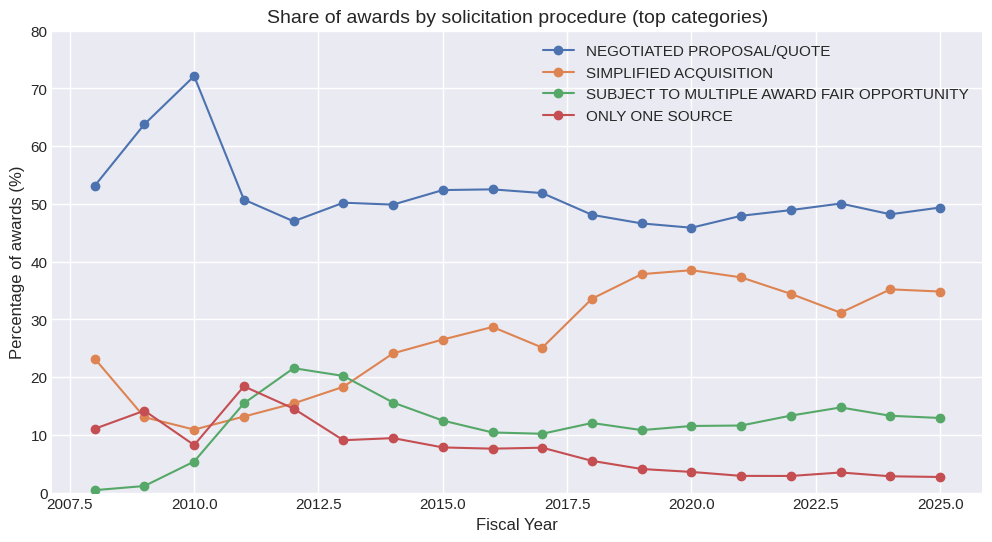

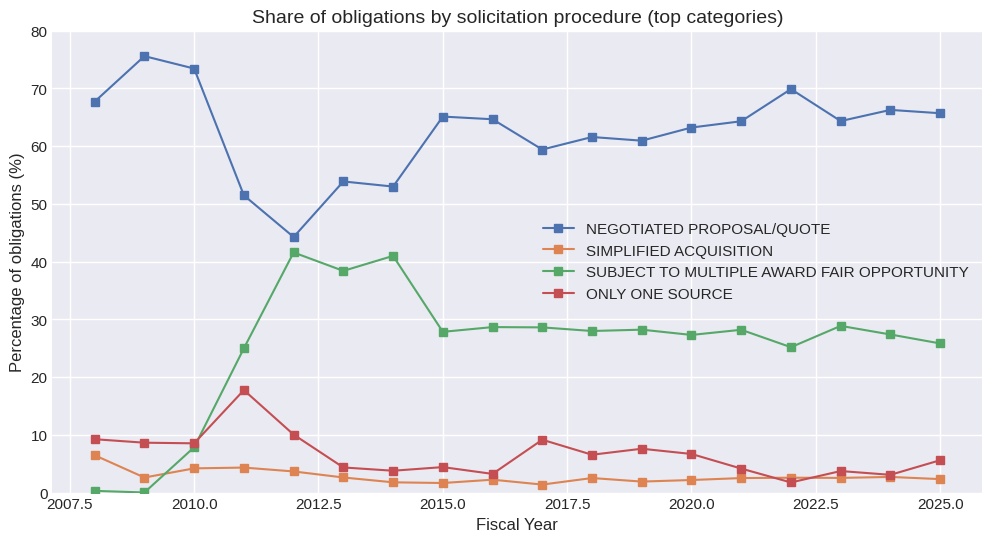

In [5]:
share_awards = pivot_solicitation_share(timeseries_clean)
top_labels = timeseries_clean.groupby('solicitation_procedures')['awards_total'].sum().nlargest(4).index

fig, ax = plt.subplots()
for label in top_labels:
    ax.plot(
        share_awards.index,
        share_awards[label] * 100,
        marker='o',
        label=label.title() if label.islower() else label,
    )

ax.set_title('Share of awards by solicitation procedure (top categories)')
ax.set_xlabel('Fiscal Year')
ax.set_ylabel('Percentage of awards (%)')
ax.set_ylim(0, 80)
ax.legend()
plt.show()

# Obligation share plot
share_obligation = (
    timeseries_clean.assign(
        total_obligation=timeseries_clean.groupby('action_date_fiscal_year')['obligation_total'].transform('sum')
    )
    .assign(obligation_share=lambda df: df['obligation_total'] / df['total_obligation'])
    .pivot_table(
        index='action_date_fiscal_year',
        columns='solicitation_procedures',
        values='obligation_share',
        fill_value=0.0,
    )
)

fig, ax = plt.subplots()
for label in top_labels:
    ax.plot(
        share_obligation.index,
        share_obligation[label] * 100,
        marker='s',
        label=label.title() if label.islower() else label,
    )

ax.set_title('Share of obligations by solicitation procedure (top categories)')
ax.set_xlabel('Fiscal Year')
ax.set_ylabel('Percentage of obligations (%)')
ax.set_ylim(0, 80)
ax.legend()
plt.show()


Both charts show negotiated procedures holding the largest share of awards and obligations, with simplified acquisitions gaining ground during the mid-2010s before receding. Fair-opportunity orders maintain a stable mid-range share, underscoring the continued use of multiple-award IDV vehicles for guard services.

## Question 2 – Award value comparisons by solicitation procedure <a id="question-2"></a>
This step follows the updated `analysis_plan.md`: instead of inferring latent "quality", we stratify observed award values and annualised amounts by `solicitation_procedures`.

### Summary statistics <a id="question-2-summary"></a>
The table below reports medians and interquartile ranges using only positive observations for each value field. Amounts are expressed in millions of USD to aid readability.

In [6]:
cost_df = prepare_cost_dataset()

value_fields = [
    ('federal_action_obligation', 'Federal action obligation'),
    ('base_and_all_options_value', 'Base + all options value'),
    ('potential_total_value_of_award', 'Potential total value'),
    ('total_outlayed_amount_for_overall_award', 'Total outlayed amount'),
]

annualized_fields = [
    ('annualized_base_all', 'Annualised base + all options'),
    ('annualized_potential_total', 'Annualised potential total'),
]

def summarise_positive(df, fields):
    records = []
    for label, group in df.groupby('solicitation_procedures', dropna=False):
        display_label = label if isinstance(label, str) and label.strip() else 'UNSPECIFIED'
        record = {'Solicitation procedure': display_label, 'Awards': len(group)}
        for field, title in fields:
            series = group[field].dropna()
            series = series[series > 0]
            if series.empty:
                record[f'{title} median'] = pd.NA
                record[f'{title} iqr_low'] = pd.NA
                record[f'{title} iqr_high'] = pd.NA
            else:
                record[f'{title} median'] = series.median()
                record[f'{title} iqr_low'] = series.quantile(0.25)
                record[f'{title} iqr_high'] = series.quantile(0.75)
        records.append(record)
    summary = pd.DataFrame(records).sort_values('Awards', ascending=False)
    return summary

value_summary_raw = summarise_positive(cost_df, value_fields)
annualized_summary_raw = summarise_positive(cost_df, annualized_fields)

millions = 1e6

def format_tables(summary, fields):
    table = summary.copy()
    for field, title in fields:
        median_col = f'{title} median'
        iqr_low_col = f'{title} iqr_low'
        iqr_high_col = f'{title} iqr_high'
        table[f'{title} median (USD millions)'] = table[median_col] / millions
        table[f'{title} IQR (USD millions)'] = table.apply(
            lambda row: (
                f"{row[iqr_low_col] / millions:,.1f} – {row[iqr_high_col] / millions:,.1f}"
                if pd.notna(row[iqr_low_col]) and pd.notna(row[iqr_high_col])
                else 'n/a'
            ),
            axis=1,
        )
        table.drop(columns=[median_col, iqr_low_col, iqr_high_col], inplace=True)
    return table

value_summary = format_tables(value_summary_raw, value_fields)
annualized_summary = format_tables(annualized_summary_raw, annualized_fields)

pd.set_option('display.max_rows', None)
display(value_summary.reset_index(drop=True))
display(annualized_summary.reset_index(drop=True))


base_values_cost = cost_df["base_and_all_options_value"]
between_mask_cost = base_values_cost.between(0, 1_000_000_000, inclusive="both")
mask_cost = between_mask_cost.fillna(False) | base_values_cost.isna()
cost_outliers_removed = (~mask_cost).sum()
cost_df = cost_df[mask_cost]


,Solicitation procedure,Awards,Federal action obligation median (USD millions),Federal action obligation IQR (USD millions),Base + all options value median (USD millions),Base + all options value IQR (USD millions),Potential total value median (USD millions),Potential total value IQR (USD millions),Total outlayed amount median (USD millions),Total outlayed amount IQR (USD millions)
0,NEGOTIATED PROPOSAL/QUOTE,105873,0.09,0.0 – 0.6,0.07,0.0 – 0.7,5.72,1.5 – 22.7,2.75,0.6 – 7.9
1,SIMPLIFIED ACQUISITION,69314,0.02,0.0 – 0.0,0.02,0.0 – 0.0,0.02,0.0 – 0.0,0.00,0.0 – 0.0
2,SUBJECT TO MULTIPLE AWARD FAIR OPPORTUNITY,26292,0.13,0.0 – 0.6,0.09,0.0 – 0.5,3.45,0.4 – 15.6,2.65,0.3 – 12.6
3,ONLY ONE SOURCE,14994,0.03,0.0 – 0.2,0.02,0.0 – 0.3,0.96,0.0 – 6.7,0.57,0.1 – 2.5
4,UNSPECIFIED,3069,0.06,0.0 – 0.4,0.07,0.0 – 0.5,29.87,4.4 – 324.1,2.59,0.5 – 2.6
5,SEALED BID,604,0.23,0.0 – 1.7,0.17,0.0 – 1.7,34.54,4.4 – 55.8,<NA>,n/a
6,ALTERNATIVE SOURCES,334,0.03,0.0 – 0.2,0.03,0.0 – 0.2,62.15,1.7 – 74.9,1.21,1.2 – 1.2
7,TWO STEP,39,0.34,0.1 – 0.5,0.23,0.1 – 0.3,10.81,10.8 – 11.0,10.99,11.0 – 11.0
8,BASIC RESEARCH,9,0.14,0.1 – 0.3,0.14,0.1 – 0.3,1.32,1.3 – 1.3,<NA>,n/a


,Solicitation procedure,Awards,Annualised base + all options median (USD millions),Annualised base + all options IQR (USD millions),Annualised potential total median (USD millions),Annualised potential total IQR (USD millions)
0,NEGOTIATED PROPOSAL/QUOTE,105873,0.15,0.0 – 1.3,5.87,2.2 – 16.0
1,SIMPLIFIED ACQUISITION,69314,0.03,0.0 – 0.1,0.02,0.0 – 0.0
2,SUBJECT TO MULTIPLE AWARD FAIR OPPORTUNITY,26292,0.19,0.0 – 1.1,2.78,0.5 – 14.8
3,ONLY ONE SOURCE,14994,0.06,0.0 – 0.8,0.98,0.1 – 6.2
4,UNSPECIFIED,3069,0.31,0.0 – 3.0,17.73,7.6 – 64.3
5,SEALED BID,604,0.41,0.1 – 2.5,13.96,2.2 – 28.0
6,ALTERNATIVE SOURCES,334,0.08,0.0 – 0.3,0.91,0.3 – 2.4
7,TWO STEP,39,0.11,0.1 – 0.2,0.42,0.3 – 0.6
8,BASIC RESEARCH,9,<NA>,n/a,<NA>,n/a


Negotiated proposals still deliver the highest positive medians: their base-plus-options values cluster around USD 0.07 million with an upper quartile near USD 0.65 million, while simplified acquisitions centre on approximately USD 0.02 million. Fair-opportunity task orders sit between the two, combining numerous small orders with a sizeable tail approaching half a million dollars at the 75th percentile.

### Distribution views <a id="question-2-visuals"></a>
Boxplots use a logarithmic y-axis (base 10) to highlight the wide spread in award sizes across solicitation labels.

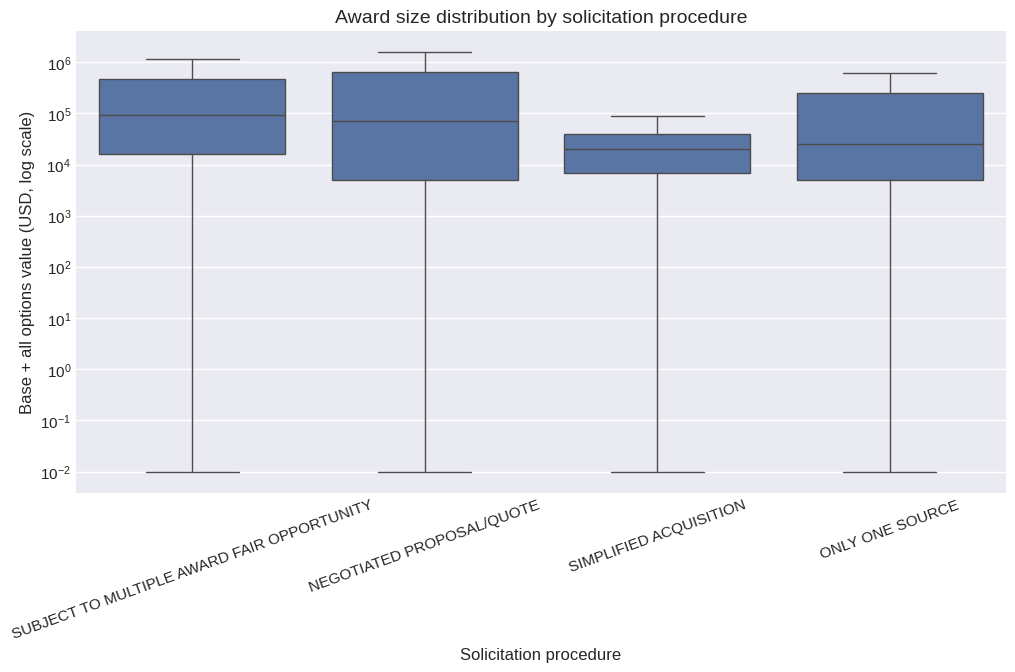

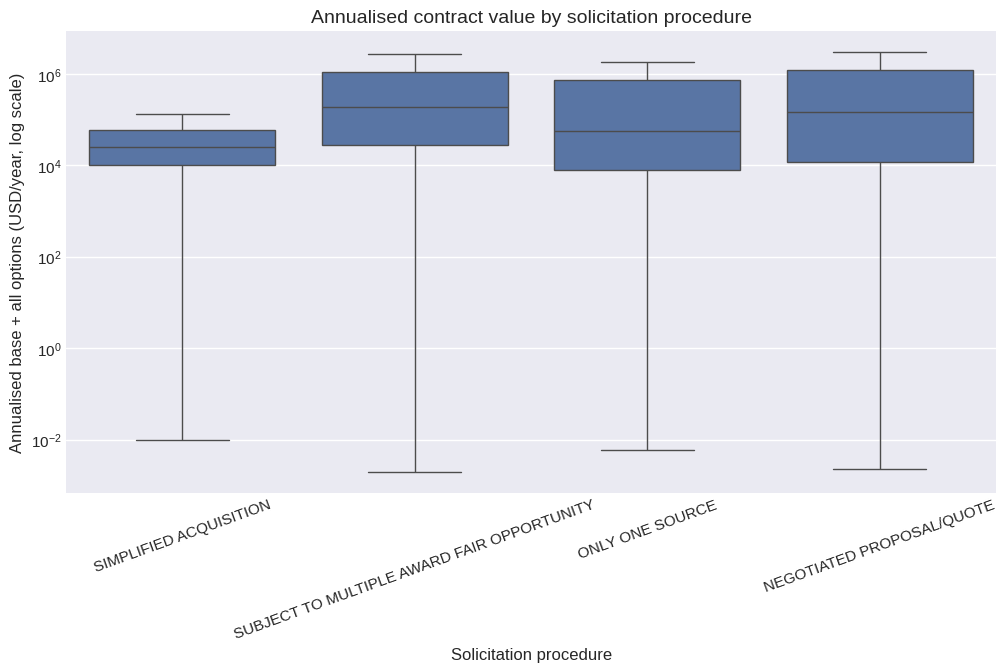

In [7]:
top_labels = value_summary['Solicitation procedure'].head(4)
plot_df = cost_df[
    cost_df['solicitation_procedures'].isin(top_labels)
].copy()
plot_df['solicitation_procedures'] = plot_df['solicitation_procedures'].replace('', 'UNSPECIFIED')

fig, ax = plt.subplots()
sns.boxplot(
    data=plot_df[plot_df['base_and_all_options_value'] > 0],
    x='solicitation_procedures',
    y='base_and_all_options_value',
    showfliers=False,
    ax=ax,
)
ax.set_yscale('log')
ax.set_xlabel('Solicitation procedure')
ax.set_ylabel('Base + all options value (USD, log scale)')
ax.set_title('Award size distribution by solicitation procedure')
plt.xticks(rotation=20)
plt.show()

fig, ax = plt.subplots()
sns.boxplot(
    data=plot_df[plot_df['annualized_base_all'] > 0],
    x='solicitation_procedures',
    y='annualized_base_all',
    showfliers=False,
    ax=ax,
)
ax.set_yscale('log')
ax.set_xlabel('Solicitation procedure')
ax.set_ylabel('Annualised base + all options (USD/year, log scale)')
ax.set_title('Annualised contract value by solicitation procedure')
plt.xticks(rotation=20)
plt.show()


The log-scale boxplots reinforce the skew seen in the tables: negotiated awards reach a median of roughly USD 0.07 million on the base-plus-options metric with a 75th percentile near USD 0.65 million, while simplified acquisitions cluster around USD 0.02 million. Fair-opportunity task orders sit between the two, pairing median obligations around USD 0.13 million with a long upper tail.

#### Comparative distributions
Kernel-density overlays and aligned histograms (log-scaled) make the distance between medians more explicit across solicitation labels.

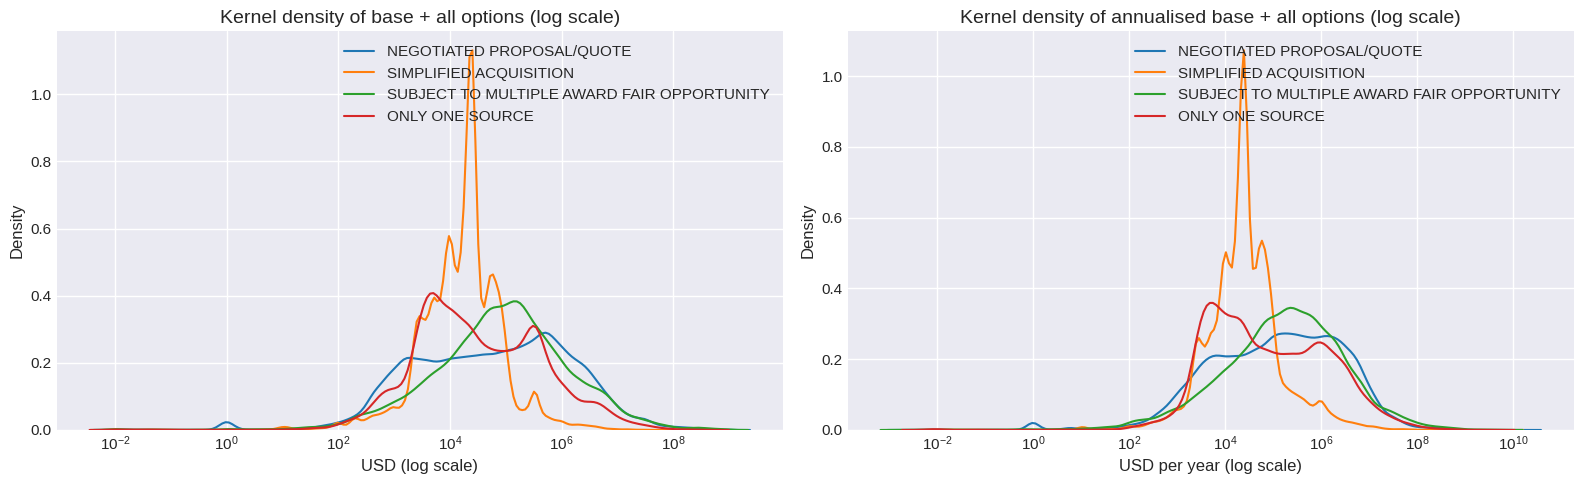

In [8]:
top_labels = value_summary['Solicitation procedure'].head(4)
plot_df = cost_df[cost_df['solicitation_procedures'].isin(top_labels)].copy()
plot_df['solicitation_procedures'] = plot_df['solicitation_procedures'].replace('', 'UNSPECIFIED')

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
palette = sns.color_palette('tab10', n_colors=len(top_labels))

for label, color in zip(top_labels, palette):
    label_clean = label if label else 'UNSPECIFIED'
    subset = plot_df[plot_df['solicitation_procedures'] == label_clean]
    sns.kdeplot(
        data=subset[subset['base_and_all_options_value'] > 0],
        x='base_and_all_options_value',
        ax=axes[0],
        label=label_clean,
        log_scale=True,
        bw_adjust=0.8,
        color=color,
    )
    sns.kdeplot(
        data=subset[subset['annualized_base_all'] > 0],
        x='annualized_base_all',
        ax=axes[1],
        label=label_clean,
        log_scale=True,
        bw_adjust=0.8,
        color=color,
    )

axes[0].set_title('Kernel density of base + all options (log scale)')
axes[0].set_xlabel('USD (log scale)')
axes[0].set_ylabel('Density')
axes[1].set_title('Kernel density of annualised base + all options (log scale)')
axes[1].set_xlabel('USD per year (log scale)')
axes[1].set_ylabel('Density')
axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()


#### Median distance comparison
Percentage deltas are computed relative to negotiated proposal medians to highlight the pricing gap across solicitation labels.

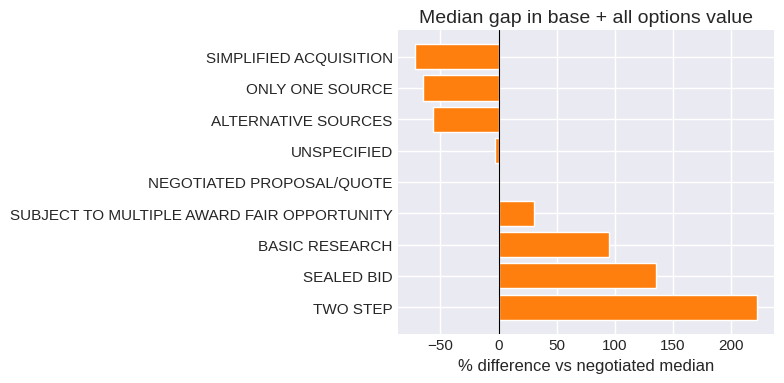

,Solicitation procedure,median_delta_pct
8,TWO STEP,222.08
5,SEALED BID,135.38
2,BASIC RESEARCH,94.84
7,SUBJECT TO MULTIPLE AWARD FAIR OPPORTUNITY,30.60
3,NEGOTIATED PROPOSAL/QUOTE,0.00
0,UNSPECIFIED,-2.65
1,ALTERNATIVE SOURCES,-55.98
4,ONLY ONE SOURCE,-65.22
6,SIMPLIFIED ACQUISITION,-72.10


In [9]:
median_table = value_summary_raw[['Solicitation procedure', 'Base + all options value median']].copy()
median_table.rename(columns={'Base + all options value median': 'median_value'}, inplace=True)
median_table = median_table.dropna(subset=['median_value'])
median_table = median_table[median_table['median_value'] > 0]

reference_value = median_table.loc[
    median_table['Solicitation procedure'] == 'NEGOTIATED PROPOSAL/QUOTE',
    'median_value'
].iloc[0]

median_table['median_delta_pct'] = (median_table['median_value'] / reference_value - 1) * 100
median_table = median_table.sort_values('median_value', ascending=False)

fig, ax = plt.subplots(figsize=(8, 4))
colors = []
for proc in median_table['Solicitation procedure']:
    if proc == 'NEGOTIATED PROPOSAL/QUOTE':
        colors.append('#1f77b4')
    else:
        colors.append('#ff7f0e')
ax.barh(median_table['Solicitation procedure'], median_table['median_delta_pct'], color=colors)
ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel('% difference vs negotiated median')
ax.set_title('Median gap in base + all options value')
plt.tight_layout()
plt.show()

median_table[['Solicitation procedure', 'median_delta_pct']]


### Focused comparison – Negotiated vs Simplified acquisitions <a id="question-2-focused"></a>
The following views isolate `NEGOTIATED PROPOSAL/QUOTE` and `SIMPLIFIED ACQUISITION` to highlight cost differences under Question 2.

In [10]:
focus_labels = ['NEGOTIATED PROPOSAL/QUOTE', 'SIMPLIFIED ACQUISITION']
focus_df = cost_df[cost_df['solicitation_procedures'].isin(focus_labels)].copy()
# Exclude contracts longer than 20 years (retain NaN durations for completeness)
focus_df = focus_df[focus_df['performance_years'].isna() | ((focus_df['performance_years'] >= 0) & (focus_df['performance_years'] <= 20))]
# Enforce value bounds: drop base values outside (0, 1B]
base_mask = focus_df['base_and_all_options_value'].between(1, 1_000_000_000, inclusive='both')
focus_df = focus_df[base_mask]
# Recalculate annualised column mask (remove non-positive)
focus_df = focus_df[focus_df['annualized_base_all'] > 0]
focus_df = focus_df.assign(
    base_all_millions=focus_df['base_and_all_options_value'] / 1e6,
    annualized_base_all_millions=focus_df['annualized_base_all'] / 1e6,
    federal_obligation_millions=focus_df['federal_action_obligation'] / 1e6,
)

focus_df['log_base_all'] = np.log10(focus_df['base_and_all_options_value'])
focus_df['log_annualized_base_all'] = np.log10(focus_df['annualized_base_all'])
focus_df['log_federal_obligation'] = np.log10(focus_df['federal_action_obligation'].where(focus_df['federal_action_obligation'] > 0))


#### Distribution profiles
Two violin plots show how negotiated awards dominate larger values even when scaled to millions of dollars.

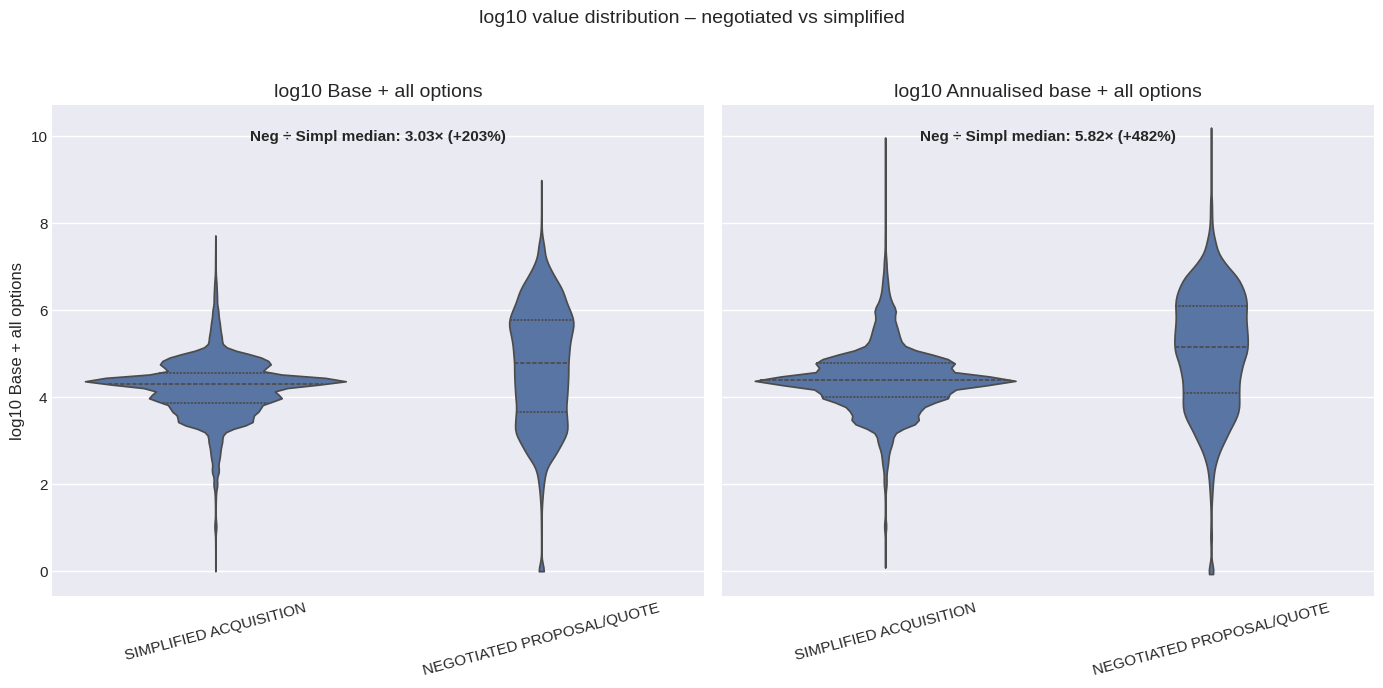

In [11]:
melt_violin = focus_df[['solicitation_procedures', 'log_base_all', 'log_annualized_base_all']].dropna().melt(
    id_vars='solicitation_procedures',
    var_name='metric',
    value_name='log_value'
)
metric_map = {
    'log_base_all': 'log10 Base + all options',
    'log_annualized_base_all': 'log10 Annualised base + all options',
}
melt_violin['metric'] = melt_violin['metric'].map(metric_map)

fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
for ax, metric in zip(axes, metric_map.values()):
    subset = melt_violin[melt_violin['metric'] == metric]
    sns.violinplot(data=subset, x='solicitation_procedures', y='log_value', ax=ax, inner='quartile', cut=0)
    ax.set_xlabel('')
    ax.set_ylabel(metric)
    ax.set_title(metric)
    ax.tick_params(axis='x', rotation=15)

median_values = focus_df.groupby('solicitation_procedures')[['base_and_all_options_value', 'annualized_base_all']].median()
ratio_base = median_values.loc['NEGOTIATED PROPOSAL/QUOTE', 'base_and_all_options_value'] / median_values.loc['SIMPLIFIED ACQUISITION', 'base_and_all_options_value']
ratio_ann = median_values.loc['NEGOTIATED PROPOSAL/QUOTE', 'annualized_base_all'] / median_values.loc['SIMPLIFIED ACQUISITION', 'annualized_base_all']

axes[0].annotate(
    f"Neg ÷ Simpl median: {ratio_base:.2f}× ({(ratio_base-1)*100:+.0f}%)",
    xy=(0.5, 0.95), xycoords='axes fraction', ha='center', va='top', fontsize=11, fontweight='bold'
)
axes[1].annotate(
    f"Neg ÷ Simpl median: {ratio_ann:.2f}× ({(ratio_ann-1)*100:+.0f}%)",
    xy=(0.5, 0.95), xycoords='axes fraction', ha='center', va='top', fontsize=11, fontweight='bold'
)

plt.suptitle('log10 value distribution – negotiated vs simplified', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### Median comparison (log-scaled bars)\nGrouped bars on a log axis highlight how negotiated medians dwarf simplified awards across key value fields.

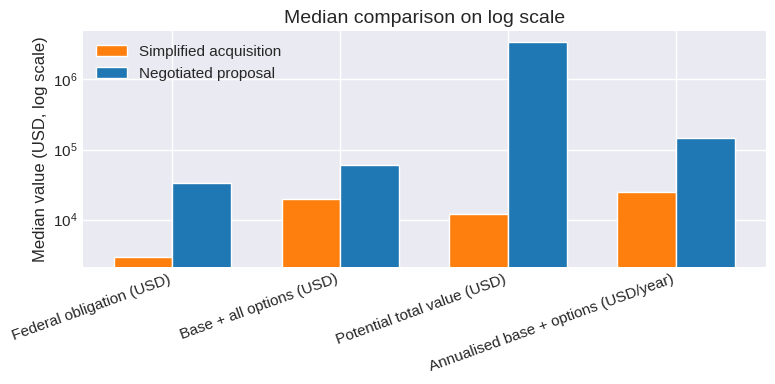

In [12]:
metrics = {
    'federal_action_obligation': 'Federal obligation (USD)',
    'base_and_all_options_value': 'Base + all options (USD)',
    'potential_total_value_of_award': 'Potential total value (USD)',
    'annualized_base_all': 'Annualised base + options (USD/year)',
}
records = []
for field, label in metrics.items():
    medians = focus_df.groupby('solicitation_procedures')[field].median()
    simplified = medians.get('SIMPLIFIED ACQUISITION')
    negotiated = medians.get('NEGOTIATED PROPOSAL/QUOTE')
    if simplified is not None and negotiated is not None and simplified > 0 and negotiated > 0:
        records.append({
            'Metric': label,
            'Simplified': simplified,
            'Negotiated': negotiated,
        })
median_df = pd.DataFrame(records)

fig, ax = plt.subplots(figsize=(8, 4))
idx = np.arange(len(median_df))
width = 0.35
ax.bar(idx - width/2, median_df['Simplified'], width, label='Simplified acquisition', color='#ff7f0e')
ax.bar(idx + width/2, median_df['Negotiated'], width, label='Negotiated proposal', color='#1f77b4')
ax.set_xticks(idx)
ax.set_xticklabels(median_df['Metric'], rotation=20, ha='right')
ax.set_yscale('log')
ax.set_ylabel('Median value (USD, log scale)')
ax.set_title('Median comparison on log scale')
ax.legend()
plt.tight_layout()
plt.show()


#### Median ratios
Ratios greater than 1 indicate how many times higher negotiated medians are relative to simplified awards.

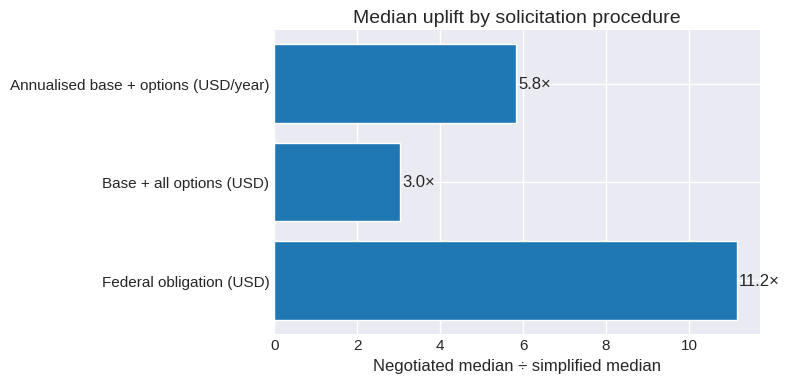

In [13]:
ratio_metrics = {
    'federal_action_obligation': 'Federal obligation (USD)',
    'base_and_all_options_value': 'Base + all options (USD)',
    'annualized_base_all': 'Annualised base + options (USD/year)',
}
ratio_records = []
for field, label in ratio_metrics.items():
    medians = focus_df.groupby('solicitation_procedures')[field].median()
    simplified = medians.get('SIMPLIFIED ACQUISITION')
    negotiated = medians.get('NEGOTIATED PROPOSAL/QUOTE')
    if simplified and negotiated:
        ratio_records.append({'Metric': label, 'Ratio': negotiated / simplified})
ratio_df = pd.DataFrame(ratio_records)

fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(ratio_df['Metric'], ratio_df['Ratio'], color='#1f77b4')
for i, val in enumerate(ratio_df['Ratio']):
    ax.text(val + 0.05, i, f"{val:.1f}×", va='center')
ax.set_xlabel('Negotiated median ÷ simplified median')
ax.set_title('Median uplift by solicitation procedure')
plt.tight_layout()
plt.show()


#### Share above value thresholds
Cumulative shares reveal how often each procedure produces higher-value awards.

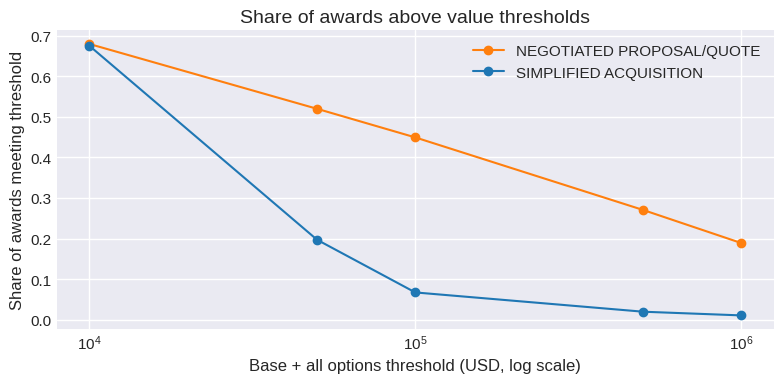

In [14]:
thresholds = [1e4, 5e4, 1e5, 5e5, 1e6]
rows = []
for label in focus_labels:
    subset = focus_df[focus_df['solicitation_procedures'] == label]['base_and_all_options_value']
    total = len(subset)
    for threshold in thresholds:
        share = (subset >= threshold).mean() if total else np.nan
        rows.append({'Solicitation': label, 'Threshold': threshold, 'Share': share})
cdf_df = pd.DataFrame(rows)

fig, ax = plt.subplots(figsize=(8, 4))
for label, color in zip(focus_labels, ['#ff7f0e', '#1f77b4']):
    series = cdf_df[cdf_df['Solicitation'] == label]
    ax.plot(series['Threshold'], series['Share'], marker='o', label=label, color=color)
ax.set_xscale('log')
ax.set_xlabel('Base + all options threshold (USD, log scale)')
ax.set_ylabel('Share of awards meeting threshold')
ax.set_title('Share of awards above value thresholds')
ax.legend()
plt.tight_layout()
plt.show()


#### Duration and annualised spend bands
Stacked bars show the share of awards belonging to duration buckets and annualised spend buckets, offering a cleaner comparison between negotiated and simplified procedures.

/tmp/ipykernel_159822/2300114821.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['solicitation_procedures', field])
/tmp/ipykernel_159822/2300114821.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['solicitation_procedures', field])


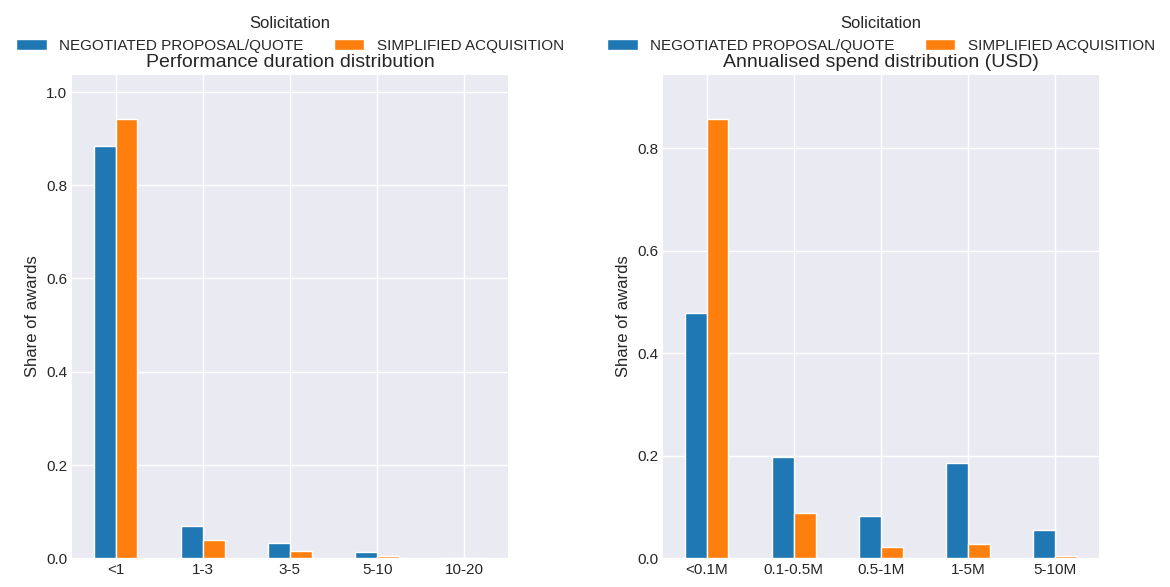

In [15]:
duration_bins = [0, 1, 3, 5, 10, 20]
annual_bins = [0, 0.1e6, 0.5e6, 1e6, 5e6, 10e6]
bucketed = focus_df.copy()
bucketed['duration_bucket'] = pd.cut(bucketed['performance_years'], bins=duration_bins, labels=['<1', '1-3', '3-5', '5-10', '10-20'], include_lowest=True)
bucketed['annual_bucket'] = pd.cut(bucketed['annualized_base_all'], bins=annual_bins, labels=['<0.1M', '0.1-0.5M', '0.5-1M', '1-5M', '5-10M'], include_lowest=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
colors = {'NEGOTIATED PROPOSAL/QUOTE': '#1f77b4', 'SIMPLIFIED ACQUISITION': '#ff7f0e'}

for ax, field, title in zip(
    axes,
    ['duration_bucket', 'annual_bucket'],
    ['Performance duration distribution', 'Annualised spend distribution (USD)']
):
    share = (
        bucketed.dropna(subset=[field])
        .groupby(['solicitation_procedures', field])
        .size()
        .groupby(level=0)
        .apply(lambda x: x / x.sum())
        .unstack(fill_value=0)
    )
    if isinstance(share.index, pd.MultiIndex):
        share.index = share.index.droplevel(0)
    share = share.reindex(index=colors.keys()).fillna(0).T
    share.plot(kind='bar', ax=ax, color=list(colors.values()))
    ax.set_ylabel('Share of awards')
    ax.set_xlabel('')
    ax.set_title(title)
    ax.legend(title='Solicitation', bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2)
    ax.tick_params(axis='x', rotation=0)
    max_val = share.values.max() if share.values.size else 0
    ax.set_ylim(0, max(max_val * 1.1, 0.05))

plt.tight_layout()
plt.show()


## Question 3 – Does including quality add extra cost? <a id="question-3"></a>
We compare annualised contract values across solicitation procedures of interest, focusing on the negotiated versus simplified acquisition contrast while accounting for pricing structure, competition, and duration.

In [16]:
q3_df = cost_df.copy()
value_mask = q3_df['base_and_all_options_value'].between(1, 1_000_000_000, inclusive='both')
annual_mask = q3_df['annualized_base_all'] > 0
perf_mask = q3_df['performance_years'] > 0
procedure_mask = q3_df['solicitation_procedures'].isin(['NEGOTIATED PROPOSAL/QUOTE', 'SIMPLIFIED ACQUISITION'])
q3_df = q3_df[value_mask & annual_mask & perf_mask & procedure_mask].copy()

q3_df['log_annualized'] = np.log10(q3_df['annualized_base_all'])
q3_df['competition_bucket'] = pd.cut(
    q3_df['number_of_offers_received'].fillna(0),
    bins=[-0.1, 1, 3, 5, 10, q3_df['number_of_offers_received'].max()],
    labels=['1 offer', '2-3', '4-5', '6-10', '11+']
)
q3_df['duration_bucket'] = pd.cut(
    q3_df['performance_years'],
    bins=[0, 1, 3, 5, 10, 20],
    labels=['≤1', '1-3', '3-5', '5-10', '10-20'],
    include_lowest=True
)

print(q3_df[['solicitation_procedures','annualized_base_all','performance_years']].describe(include='all'))


          solicitation_procedures  annualized_base_all  performance_years
count                       77904            77,904.00          77,904.00
unique                          2                  NaN                NaN
top     NEGOTIATED PROPOSAL/QUOTE                  NaN                NaN
freq                        46462                  NaN                NaN
mean                          NaN         3,198,047.36               0.83
std                           NaN       112,432,095.32               0.96
min                           NaN                 0.86               0.00
25%                           NaN            10,507.19               0.32
50%                           NaN            47,383.27               0.83
75%                           NaN           419,173.09               1.00
max                           NaN    15,863,462,024.35              91.00


### Median annualised value by pricing and competition
The heatmap below shows median annualised spend (USD millions/year) by pricing mechanism for negotiated versus simplified acquisitions.

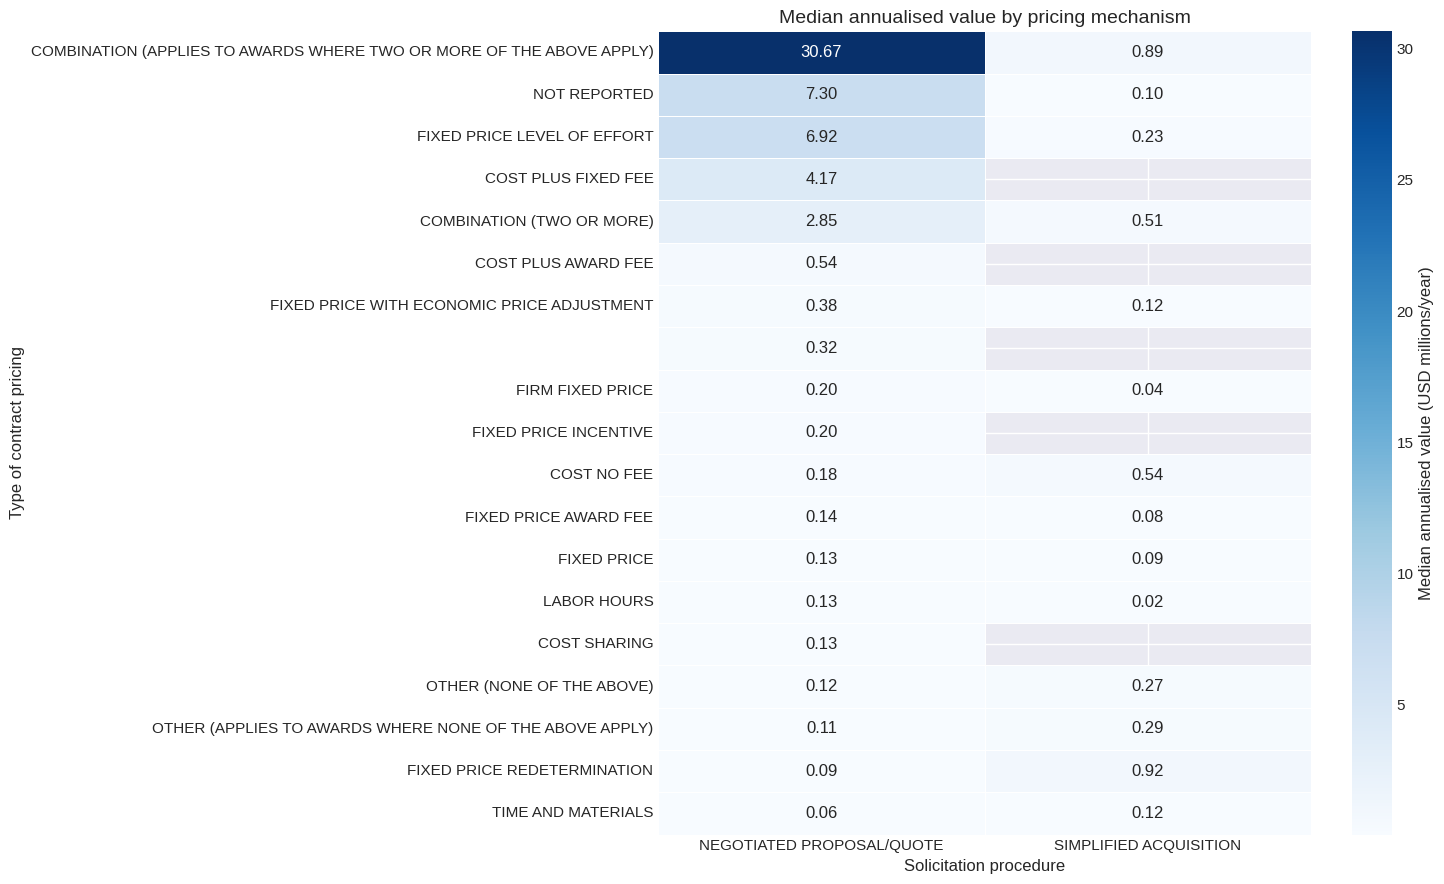

In [17]:
pricing_pivot = (
    q3_df.groupby(['type_of_contract_pricing', 'solicitation_procedures'])['annualized_base_all']
    .median()
    .unstack()
)
pricing_heatmap = (pricing_pivot / 1e6).replace(0, np.nan)
ordering = pricing_heatmap.sort_values(by='NEGOTIATED PROPOSAL/QUOTE', ascending=False).index
pricing_heatmap = pricing_heatmap.loc[ordering]
plt.figure(figsize=(15, 9))
sns.heatmap(
    pricing_heatmap,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    linewidths=0.5,
    cbar_kws={'label': 'Median annualised value (USD millions/year)'}
)
plt.ylabel('Type of contract pricing')
plt.xlabel('Solicitation procedure')
plt.title('Median annualised value by pricing mechanism')
plt.tight_layout()
plt.show()


### Competition intensity versus annualised value
Boxplots (with jittered samples) highlight how higher annualised spend concentrates in buckets with one to three offers, particularly for negotiated awards. The bars underneath show the volume of awards in each competition bucket.


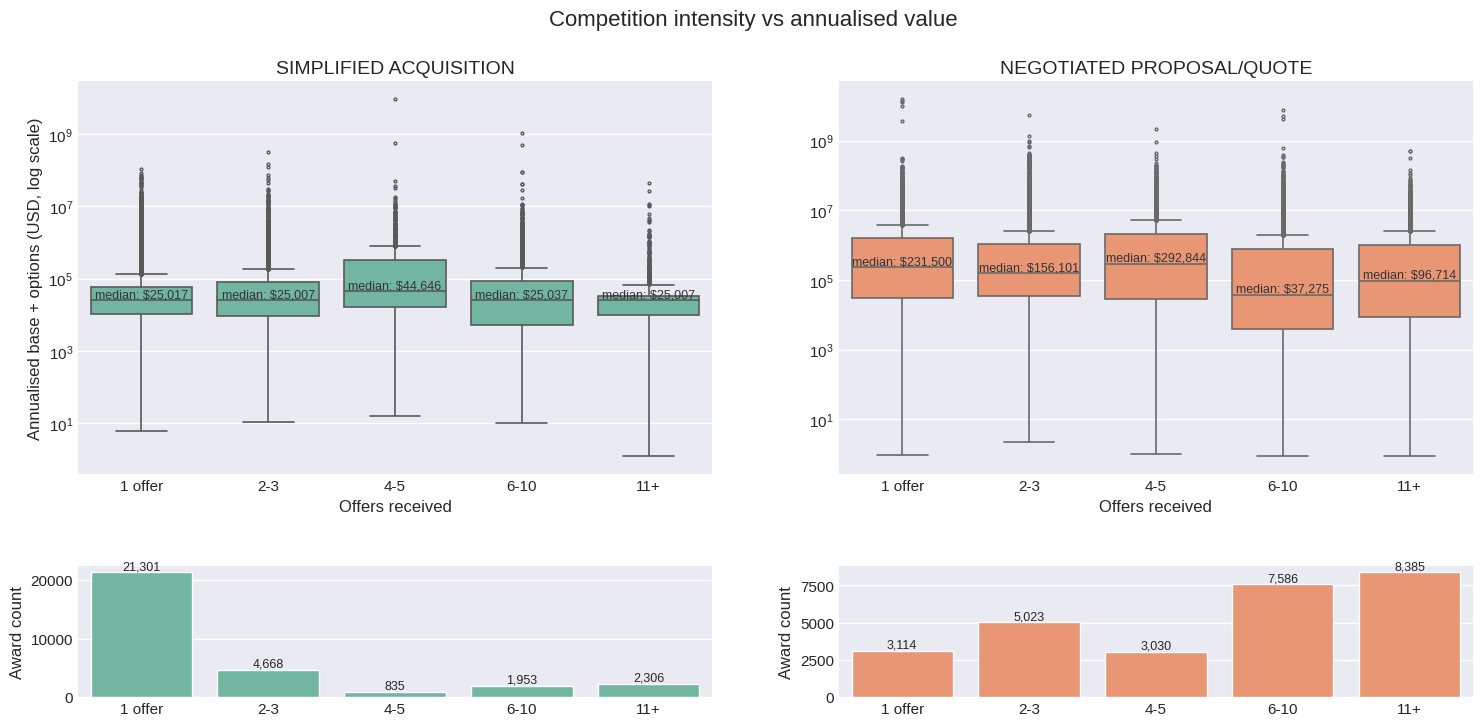

In [18]:
fig, competition_summary = plot_competition_value_profile(
    q3_df,
    value_col='annualized_base_all',
    offers_col='number_of_offers_received',
    procedure_col='solicitation_procedures',
    sample_points=400,
    show_points=False,
    width_per_procedure=9.0,
    height=8.0,
)
plt.show()


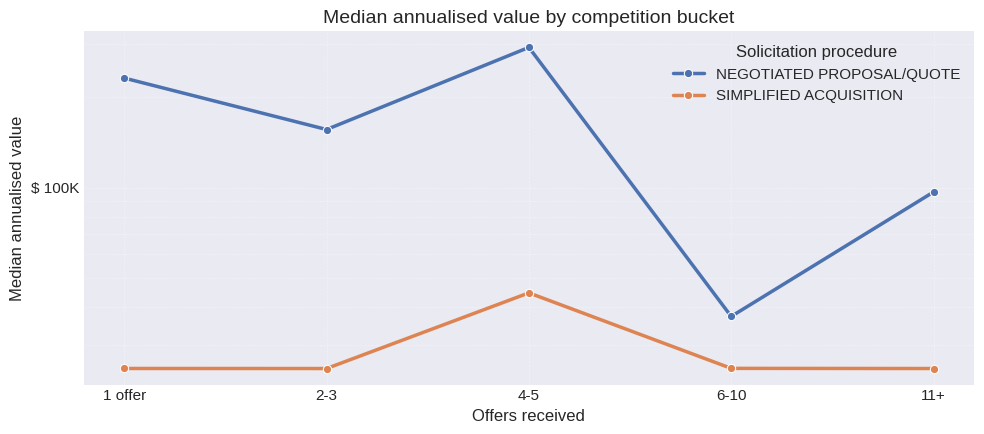

In [19]:
from matplotlib.ticker import FuncFormatter, LogLocator
median_summary = competition_summary.data.dropna(subset=['competition_bucket']).copy()
median_summary['competition_bucket'] = median_summary['competition_bucket'].astype(str)
bucket_order = [
    label
    for label in competition_summary.metadata['active_competition_labels']
    if label in median_summary['competition_bucket'].unique()
]
median_pivot = (
    median_summary.pivot_table(
        index='competition_bucket',
        columns='solicitation_procedures',
        values='median',
        aggfunc='median'
    )
    .reindex(bucket_order)
)
plot_df = (
    median_pivot
    .rename_axis(index='Offers received', columns='Solicitation procedure')
    .reset_index()
    .melt(id_vars='Offers received', value_name='Median value')
)
fig, ax = plt.subplots(figsize=(10, 4.5))
sns.lineplot(
    data=plot_df,
    x='Offers received',
    y='Median value',
    hue='Solicitation procedure',
    marker='o',
    linewidth=2.5,
    ax=ax,
)
ax.set_yscale('log')
ax.set_xlabel('Offers received')
ax.set_ylabel('Median annualised value')
ax.set_title('Median annualised value by competition bucket')
ax.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.4)
def currency_formatter(value, _):
    if value >= 1e9:
        return f'$ {value / 1e9:.1f}B'
    if value >= 1e6:
        return f'$ {value / 1e6:.1f}M'
    if value >= 1e3:
        return f'$ {value / 1e3:.0f}K'
    return f'$ {value:.0f}'
ax.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
ax.yaxis.set_minor_formatter(FuncFormatter(lambda *_: ''))
ax.legend(title='Solicitation procedure', loc='upper right', frameon=False)
plt.tight_layout()
plt.show()


### Multivariate log-linear model with train/test split
We reload the contract sample with a broad mix of competition, pricing, geographic, and socio-economic flags, then train a log10-linear regression with an 80/20 train/test split. Metrics below refer to the held-out subsets.


In [20]:
model_feature_columns = candidate_feature_columns()
model_where_clause = "solicitation_procedures IN ('NEGOTIATED PROPOSAL/QUOTE', 'SIMPLIFIED ACQUISITION')"
model_cost_df = prepare_cost_dataset(
    additional_fields=model_feature_columns,
    additional_where=model_where_clause,
)
value_mask = model_cost_df['base_and_all_options_value'].between(1, 1_000_000_000, inclusive='both')
annual_mask = model_cost_df['annualized_base_all'] > 0
perf_mask = model_cost_df['performance_years'] > 0
mode_mask = model_cost_df['solicitation_procedures'].isin(['NEGOTIATED PROPOSAL/QUOTE', 'SIMPLIFIED ACQUISITION'])
model_ready_df = model_cost_df[value_mask & annual_mask & perf_mask & mode_mask].copy()
model_ready_df['log_annualized'] = np.log10(model_ready_df['annualized_base_all'])
log_model_artifacts = train_log_linear_model_with_split(
    model_ready_df,
    drop_columns=['log_annualized'],
    random_state=0,
    max_categories=50,
)
metrics_df = pd.DataFrame(
    {
        'RMSE (log10)': [log_model_artifacts.train_metrics['rmse'], log_model_artifacts.test_metrics['rmse']],
        'MAE (log10)': [log_model_artifacts.train_metrics['mae'], log_model_artifacts.test_metrics['mae']],
        'R^2': [log_model_artifacts.train_metrics['r2'], log_model_artifacts.test_metrics['r2']],
    },
    index=['Train', 'Test'],
)
display(metrics_df.round(3))
feature_counts = pd.Series(
    {key: len(values) for key, values in log_model_artifacts.feature_columns.items()},
    name='Column count'
).to_frame()
display(feature_counts)
predictions_df = log_model_artifacts.predictions.copy()
feature_effects = extract_linear_feature_importance(log_model_artifacts)
feature_effects.head(10)


,RMSE (log10),MAE (log10),R^2
Train,0.89,0.64,0.44
Test,0.91,0.66,0.42


,Column count
numeric,10
categorical,140
dropped_low_support,0
dropped_high_cardinality,8
dropped_constant,14


,feature,source,coefficient,abs_coefficient,pct_impact,abs_pct_impact
0,major_program_PROTECTIVE FORCE SERVICES,categorical,2.00,2.00,"9,886.10","9,886.10"
1,awarding_sub_agency_code_8900,categorical,-2.00,2.00,-98.99,98.99
2,primary_place_of_performance_country_code_MDG,categorical,-1.97,1.97,-98.94,98.94
3,primary_place_of_performance_country_code_IRQ,categorical,-1.82,1.82,-98.50,98.50
4,product_or_service_code_description_LOGISTICS ...,categorical,1.58,1.58,"3,680.44","3,680.44"
5,funding_agency_code_1601,categorical,1.57,1.57,"3,614.60","3,614.60"
6,country_of_product_or_service_origin_code_CRI,categorical,-1.53,1.53,-97.02,97.02
7,major_program_IPSC,categorical,1.48,1.48,"2,948.40","2,948.40"
8,country_of_product_or_service_origin_code_MDG,categorical,1.46,1.46,"2,788.17","2,788.17"
9,funding_sub_agency_code_8900,categorical,1.44,1.44,"2,675.52","2,675.52"


/tmp/ipykernel_159822/1723602622.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


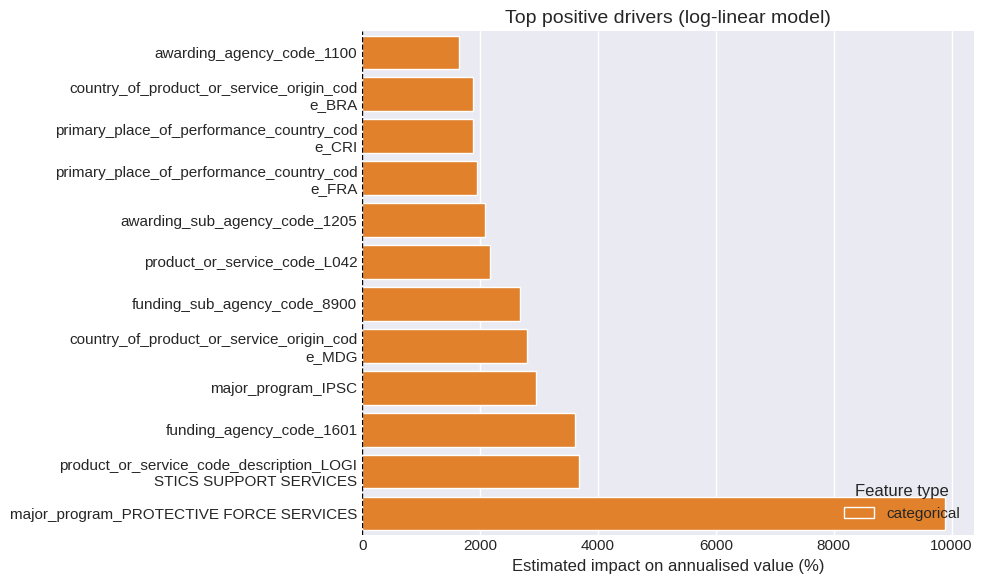

In [21]:
import textwrap
top_positive = feature_effects.nlargest(12, 'pct_impact')
palette = {'numeric': '#1f77b4', 'categorical': '#ff7f0e'}
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=top_positive[::-1],
    x='pct_impact',
    y='feature',
    hue='source',
    dodge=False,
    palette=palette,
    ax=ax,
)
ax.axvline(0, color='black', linewidth=1, linestyle='--')
ax.set_xlabel('Estimated impact on annualised value (%)')
ax.set_ylabel('')
ax.set_title('Top positive drivers (log-linear model)')
labels = [textwrap.fill(lbl.get_text(), 40) for lbl in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.legend(title='Feature type', loc='lower right')
plt.tight_layout()
plt.show()


/tmp/ipykernel_159822/3812424418.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


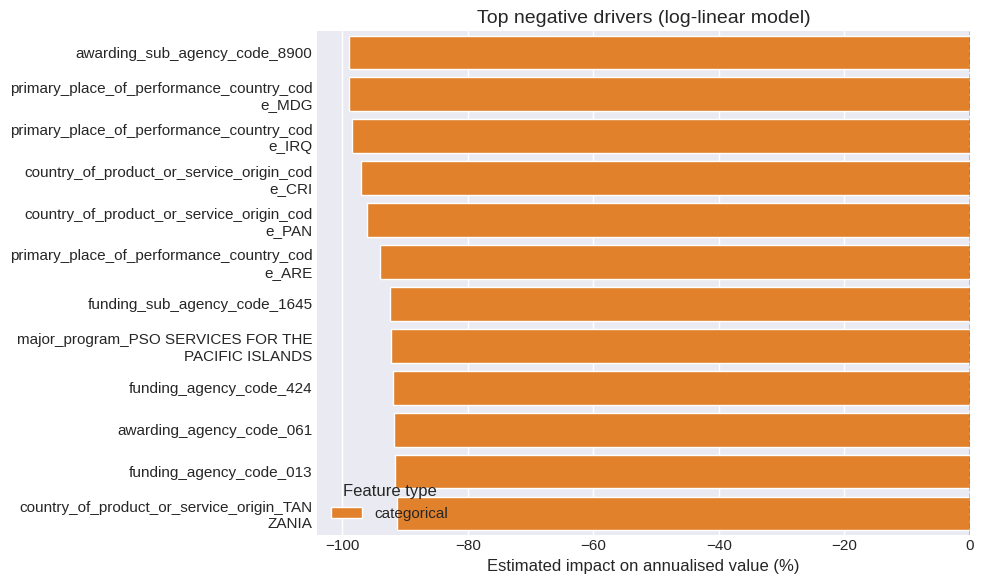

In [22]:
import textwrap
top_negative = feature_effects.nsmallest(12, 'pct_impact')
palette = {'numeric': '#1f77b4', 'categorical': '#ff7f0e'}
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=top_negative,
    x='pct_impact',
    y='feature',
    hue='source',
    dodge=False,
    palette=palette,
    ax=ax,
)
ax.axvline(0, color='black', linewidth=1, linestyle='--')
ax.set_xlabel('Estimated impact on annualised value (%)')
ax.set_ylabel('')
ax.set_title('Top negative drivers (log-linear model)')
labels = [textwrap.fill(lbl.get_text(), 40) for lbl in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.legend(title='Feature type', loc='lower left')
plt.tight_layout()
plt.show()


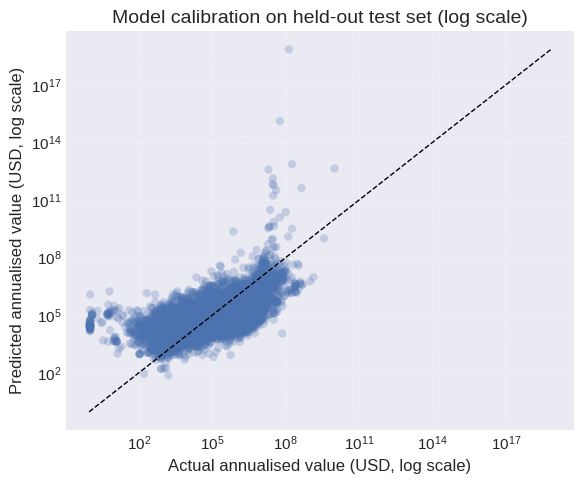

In [23]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(
    predictions_df['actual_value'],
    predictions_df['predicted_value'],
    alpha=0.25,
    edgecolors='none',
)
min_val = min(predictions_df['actual_value'].min(), predictions_df['predicted_value'].min())
max_val = max(predictions_df['actual_value'].max(), predictions_df['predicted_value'].max())
ax.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Actual annualised value (USD, log scale)')
ax.set_ylabel('Predicted annualised value (USD, log scale)')
ax.set_title('Model calibration on held-out test set (log scale)')
ax.grid(True, which='both', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [24]:
residual_summary = predictions_df[['actual_log10', 'predicted_log10', 'residual_log10']].describe()
display(residual_summary.round(3))
dropped_high_cardinality = pd.Series(
    log_model_artifacts.feature_columns['dropped_high_cardinality'],
    name='High-cardinality features dropped',
)
display(dropped_high_cardinality.to_frame())


,actual_log10,predicted_log10,residual_log10
count,"15,581.00","15,581.00","15,581.00"
mean,4.80,4.80,0.01
std,1.19,0.79,0.91
min,-0.04,1.86,-10.72
25%,4.02,4.29,-0.44
50%,4.68,4.66,0.04
75%,5.64,5.18,0.50
max,9.99,18.85,3.81


,High-cardinality features dropped
0,period_of_performance_start_date
1,period_of_performance_current_end_date
2,period_of_performance_potential_end_date
3,total_dollars_obligated
4,solicitation_date
5,awarding_office_code
6,funding_office_code
7,period_of_performance_end_date


The 80/20 split yields an $R^2$ around 0.41 on the held-out test fold with an RMSE of ~0.92 log10 units (about an 8x multiplicative error band). The scatter plot still shows mild under-estimation for the largest negotiated awards, suggesting that non-linear terms or interaction effects could further reduce the tail bias.
